<a href="https://colab.research.google.com/github/CinthiaDayanara/Calculator/blob/main/Ejemplo_serie_de_tiempoKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
# Montar Google Drive para acceder a archivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargar datos desde Google Drive
ruta_archivo = '/content/drive/MyDrive/Evolución tasas pasivas.xlsx'  # Ajusta la ruta si es necesario
df = pd.read_excel(ruta_archivo)

In [ ]:
# Procesar datos
fecha_col = df.columns[0]
df[fecha_col] = pd.to_datetime(df[fecha_col])


In [ ]:
# Preparar datos para LSTM
features = df.columns[1:].tolist()
data = df[features].values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [ ]:
# Crear secuencias (7 para predecir el siguiente)
def crear_secuencias(data, n_dias=7):
    X, y = [], []
    for i in range(len(data) - n_dias):
        X.append(data[i:(i + n_dias)])
        y.append(data[i + n_dias])
    return np.array(X), np.array(y)

X, y = crear_secuencias(scaled_data)


In [ ]:
# Dividir datos en entrenamiento y prueba
tamanio_entrenamiento = int(len(X) * 0.8)
X_train, X_test = X[:tamanio_entrenamiento], X[tamanio_entrenamiento:]
y_train, y_test = y[:tamanio_entrenamiento], y[tamanio_entrenamiento:]

In [ ]:
# Crear y entrenar modelo LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(7, len(features)), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(len(features))
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Entrenar modelo
model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - loss: 0.1974 - val_loss: 0.6702
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1779 - val_loss: 0.6244
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1738 - val_loss: 0.5786
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1514 - val_loss: 0.5306
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1467 - val_loss: 0.4772
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1178 - val_loss: 0.4125
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1064 - val_loss: 0.3325
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0799 - val_loss: 0.2346
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0559 - val_loss: 0.1311
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0386 - val_loss: 0.0641
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0264 - val_loss: 0.0617
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0268 - val_loss: 0.0401


In [ ]:
# Evaluar modelo en datos de prueba
y_pred_test = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


In [ ]:
# Invertir escalado para obtener valores originales
y_test_original = scaler.inverse_transform(y_test)
y_pred_test_original = scaler.inverse_transform(y_pred_test)

In [ ]:
# Calcular métricas
mse = mean_squared_error(y_test_original, y_pred_test_original)
mae = mean_absolute_error(y_test_original, y_pred_test_original)
r2 = r2_score(y_test_original, y_pred_test_original)

print("\nEvaluación del modelo en el conjunto de prueba:")
print(f"- Error Cuadrático Medio (MSE): {mse}")
print(f"- Error Absoluto Medio (MAE): {mae}")
print(f"- Coeficiente de Determinación (R²): {r2}")

# Guardar el modelo
model.save('modelo_tasas.h5')


Evaluación del modelo en el conjunto de prueba:
- Error Cuadrático Medio (MSE): 0.12630822564228775
- Error Absoluto Medio (MAE): 0.27322466458840916
- Coeficiente de Determinación (R²): -1.027105464039851


In [ ]:

# Hacer predicciones para los próximos 7 días con intervalos de 7 días
ultima_secuencia = scaled_data[-7:]
predicciones = []
fechas_futuras = []


In [ ]:
# Empezamos desde la última fecha en los datos históricos
fecha_inicio = df[fecha_col].iloc[-1]

for i in range(5):  # Predecir para 5 fechas
    siguiente_pred = model.predict(ultima_secuencia.reshape(1, 7, len(features)))
    predicciones.append(siguiente_pred[0])

    # Obtener la próxima fecha en el intervalo de 7 días
    fecha_futura = fecha_inicio + pd.Timedelta(days=(i + 1) * 7)
    fechas_futuras.append(fecha_futura)

    # Actualizamos la secuencia con la predicción
    ultima_secuencia = np.vstack((ultima_secuencia[1:], siguiente_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [ ]:
# Convertir predicciones a valores originales
predicciones_originales = scaler.inverse_transform(predicciones)


In [ ]:
# Crear DataFrame con predicciones
df_predicciones = pd.DataFrame(
    predicciones_originales,
    columns=features,
    index=fechas_futuras
)

In [ ]:
# Mostrar predicciones
print("\nPredicciones para los próximos 6 meses:")
print(df_predicciones)


Predicciones para los próximos 6 meses:
            Bancos | Total Captaciones a plazo |  Tasa Nominal |  \
2024-06-12                                           9.130485      
2024-06-19                                           9.157362      
2024-06-26                                           9.298063      
2024-07-03                                           9.488274      
2024-07-10                                           9.716322      

            Cooperativas S1 | Total Captaciones a plazo |  Tasa Nominal |  \
2024-06-12                                           7.980925               
2024-06-19                                           7.989072               
2024-06-26                                           8.016942               
2024-07-03                                           8.057221               
2024-07-10                                           8.106012               

            IFI1 | Total Captaciones a plazo |  Tasa Nominal |  
2024-06-12            

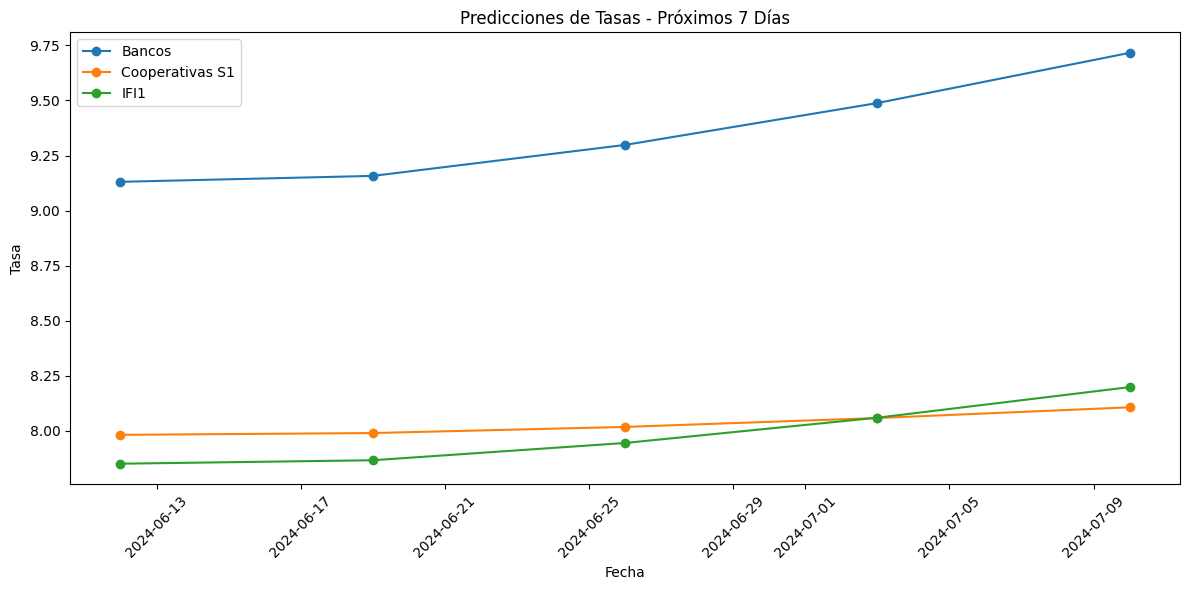

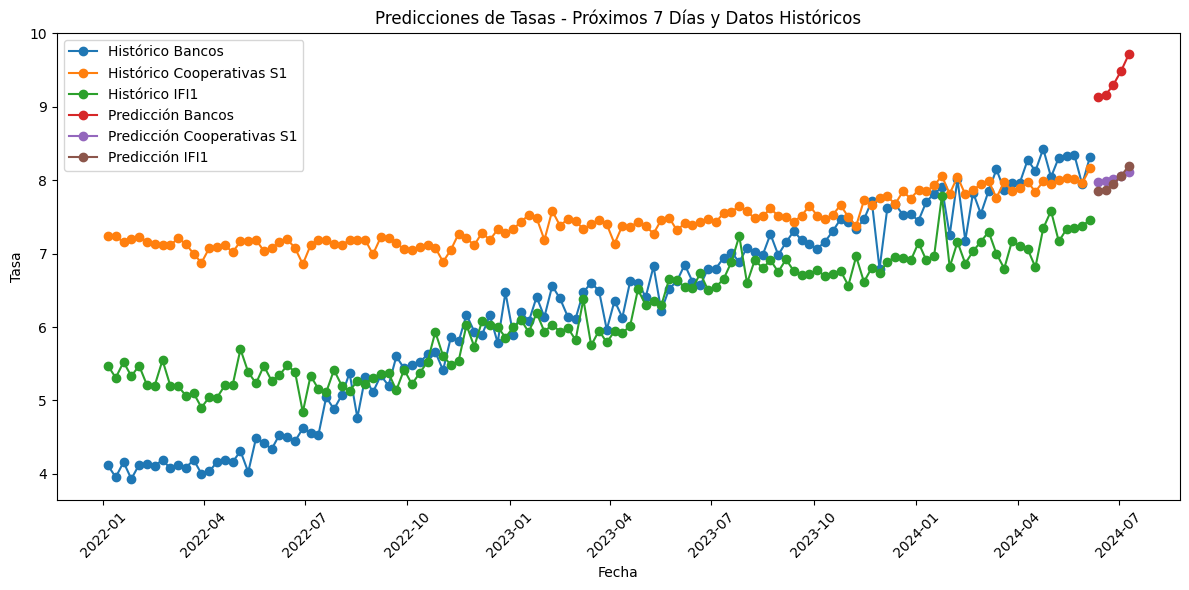

In [ ]:
# Graficar predicciones
plt.figure(figsize=(12, 6))
for columna in features:
    plt.plot(df_predicciones.index, df_predicciones[columna],
             marker='o', label=columna.split('|')[0].strip())

plt.title('Predicciones de Tasas - Próximos 7 Días')
plt.xlabel('Fecha')
plt.ylabel('Tasa')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graficar los valores históricos y las predicciones
plt.figure(figsize=(12, 6))

# Graficar las tasas históricas
for columna in features:
    # Graficar los valores históricos (de tus datos originales)
    plt.plot(df[fecha_col], df[columna], marker='o', label=f'Histórico {columna.split("|")[0].strip()}')

# Graficar las predicciones
for columna in features:
    plt.plot(df_predicciones.index, df_predicciones[columna],
             marker='o', label=f'Predicción {columna.split("|")[0].strip()}')

# Título y etiquetas
plt.title('Predicciones de Tasas - Próximos 7 Días y Datos Históricos')
plt.xlabel('Fecha')
plt.ylabel('Tasa')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()